In [1]:
import pickle

import astropy.units as u
import lightkurve as lk
import numpy as np
import pandas as pd
import yaml

tic = 369327947

targets = pd.read_csv("../data/tess-ultra-fast-rotators-brighter-mag14.csv")[
    ["Name", "LS_Period", "Amplitude", "teff_val"]
]

targets = targets.sort_values("LS_Period")
target = targets[targets.Name == tic]

name = f"TIC {tic}"
search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

# data
klc = search_result[0].download()
times = klc.time.to_value("btjd")
fluxes = klc.pdcsap_flux.to_value().filled(np.nan)
errors = klc.flux_err.to_value().filled(np.nan)
mask = np.isnan(fluxes) | np.isnan(errors) | np.isnan(times)
original_time = times[~mask]
original_flux = fluxes[~mask]
original_error = errors[~mask]

splits = np.array_split(
    np.arange(len(original_time)), np.flatnonzero(np.diff(original_time) > 0.1) + 1
)

n = 300
time = np.hstack([original_time[split[n:-n]] for split in splits])
flux = np.hstack([original_flux[split[n:-n]] for split in splits])
error = np.hstack([original_error[split[n:-n]] for split in splits])

# first exposure
first_exposure = klc.time[0]
time_format = rf"{first_exposure.format.upper()}_{{{first_exposure.scale.upper()}}}"
first_exposure_time = first_exposure.value

flux_median = np.median(original_flux)
time = time - first_exposure_time
flux /= flux_median
error /= flux_median

# stellar parameters
url = f"https://exofop.ipac.caltech.edu/tess/download_stellar.php?id={tic}"
star = pd.read_csv(url, delimiter="|", index_col=1).iloc[0]

star_dict = {
    "tic": int(tic),
    "time0": float(first_exposure_time),
    "time0_format": str(time_format),
    "star_period": float(target.LS_Period),
    "star_amplitude": float(target.Amplitude),
    "star_radius": float(star["Radius (R_Sun)"]),
    "star_mass": float(star["Mass (M_Sun)"]),
    "star_teff": float(star["Teff (K)"]),
    "star_logg": float(star["log(g)"]),
    "sector": int(klc.sector),
}



/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_28049/2760258854.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "star_period": float(target.LS_Period),
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_28049/2760258854.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "star_amplitude": float(target.Amplitude),


In [2]:
ld = pd.read_csv("../data/tess_limb_darkening.txt", delim_whitespace=True, comment="#")
closest_teff = ld.Teff.iloc[np.argmin(np.abs(ld.Teff - star_dict["star_teff"]))]
teff_ld = ld[ld.Teff == closest_teff]
ld_row = teff_ld.iloc[np.argmin(np.abs(teff_ld.logg - star_dict["star_logg"]))]
ld_coeffs = list(ld_row[["aLSM", "bLSM"]].values)

In [4]:
float(ld_coeffs[0]), float(ld_coeffs[1])

(0.2125, 0.3984)

In [42]:
list(teff_ld.iloc[np.argmin(np.abs(teff_ld.logg - star_dict["star_logg"]))][["aLSM", "bLSM"]].values)

[0.2125, 0.3984]

In [31]:
star_dict["star_teff"]

3595.0

In [24]:
star_dict

({'tic': 140212114,
  'time0': 1437.9819530443453,
  'time0_format': 'BTJD_{TDB}',
  'star_period': 0.1400778,
  'star_amplitude': 0.00775,
  'star_radius': 0.517266,
  'star_mass': 0.514858,
  'star_teff': 3595.0,
  'sector': 5},)

In [12]:
ld.iloc[np.abs(ld.Teff)]

,logg,Teff,Z,/HP,aLSM,bLSM,aPCM,bPCM,chi2,e,od
0,2.5,2300.0,0.0,2.0,0.3685,0.5069,0.2997,0.6911,0.1762,q,PC
1,3.0,2300.0,0.0,2.0,0.3895,0.4724,0.3425,0.6024,0.1609,q,PC
2,3.5,2300.0,0.0,2.0,0.4372,0.4266,0.4060,0.5174,0.1360,q,PC
3,4.0,2300.0,0.0,2.0,0.4846,0.3947,0.4707,0.4445,0.1110,q,PC
4,4.5,2300.0,0.0,2.0,0.5084,0.3663,0.4986,0.4044,0.0903,q,PC
...,...,...,...,...,...,...,...,...,...,...,...
569,4.0,12000.0,0.0,2.0,0.1244,0.2619,-0.2218,1.0331,0.1053,q,PC
570,4.5,12000.0,0.0,2.0,0.1262,0.2536,-0.1684,0.8991,0.1013,q,PC
571,5.0,12000.0,0.0,2.0,0.1283,0.2289,-0.0899,0.6995,0.0923,q,PC
572,5.5,12000.0,0.0,2.0,0.1258,0.2350,-0.0342,0.5813,0.0969,q,PC


In [5]:
import pickle

import astropy.units as u
import lightkurve as lk
import numpy as np
import pandas as pd
import yaml

tic = 369327947

name = f"TIC {tic}"
search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

# data
klc = search_result[0].download()
times = klc.time.to_value("btjd")
fluxes = klc.pdcsap_flux.to_value().filled(np.nan)
errors = klc.flux_err.to_value().filled(np.nan)
mask = np.isnan(fluxes) | np.isnan(errors) | np.isnan(times)
original_time = times[~mask]
original_flux = fluxes[~mask]
original_error = errors[~mask]

splits = np.array_split(
    np.arange(len(original_time)), np.flatnonzero(np.diff(original_time) > 0.1) + 1
)

n = 300
time = np.hstack([original_time[split[n:-n]] for split in splits])
flux = np.hstack([original_flux[split[n:-n]] for split in splits])
error = np.hstack([original_error[split[n:-n]] for split in splits])

# first exposure
first_exposure = klc.time[0]
time_format = rf"{first_exposure.format.upper()}_{{{first_exposure.scale.upper()}}}"
first_exposure_time = first_exposure.value

flux_median = np.median(original_flux)
time = time - first_exposure_time
flux /= flux_median
error /= flux_median

(5.0, 10.0)

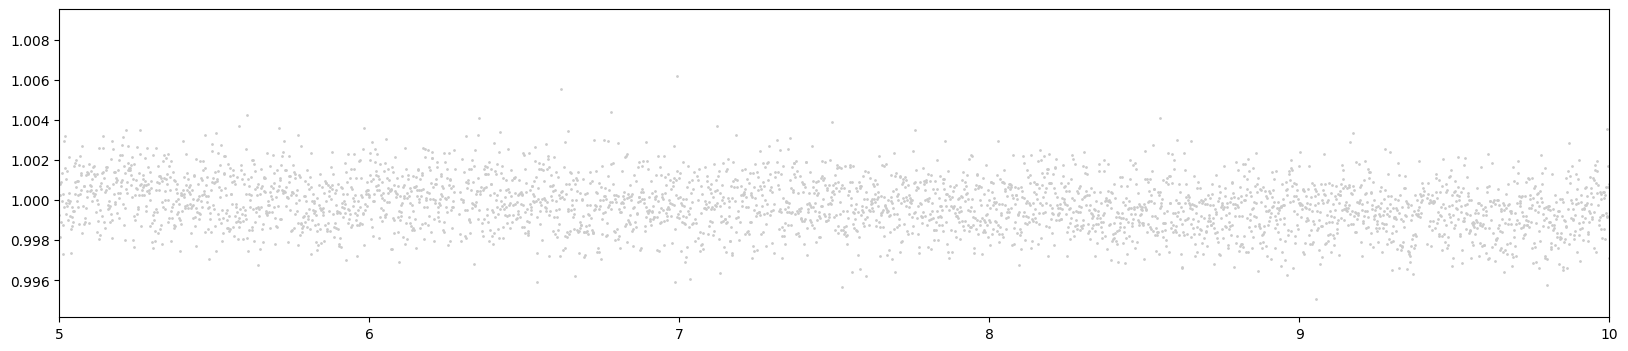

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(time, flux, ".", c="0.8", ms=2)
plt.xlim(5,10)